### 1. Imports

In [279]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import heapq
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler


### 2. Lectura de Datos

In [280]:
df = pd.read_csv("reviews_sentiment.csv", sep=';')

### 3. Promedio de palabras por estrellas

In [281]:
def meanWordsByStars(df):
    wordsByStars = {}
    for i in range(1,6):
        dfAux = df[df['Star Rating'] == i]
        wordsByStars[i] = dfAux["wordcount"].mean()
    return wordsByStars

print(meanWordsByStars(df))

{1: 12.216216216216216, 2: 41.916666666666664, 3: 8.08974358974359, 4: 16.366666666666667, 5: 4.2727272727272725}


### 4. Procesamiento del dataSet

In [282]:
df_processed = df.dropna()
print(len(df)-len(df_processed))
def string_to_float(string):
    if string == 'positive':
        return 1
    elif string == 'negative':
        return 0
    else:
        return string  # Return the original value if it's neither 'positive' nor 'negative'

df_processed['titleSentiment'] = df_processed['titleSentiment'].apply(string_to_float)
df_processed['textSentiment'] = df_processed['textSentiment'].apply(string_to_float)

#muestra el dataframe modificado
df_processed.to_csv('modified_dataframe.csv', index=False)


26


C:\Users\Agustin\AppData\Local\Temp\ipykernel_18148\1065236455.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['titleSentiment'] = df_processed['titleSentiment'].apply(string_to_float)
C:\Users\Agustin\AppData\Local\Temp\ipykernel_18148\1065236455.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['textSentiment'] = df_processed['textSentiment'].apply(string_to_float)


### 5. Conjunto de entrenamiento y variables predictoras

In [283]:
# choose the columns to be used as features for training the model
X = df_processed[['wordcount', 'titleSentiment', 'sentimentValue']]
Y = df_processed['Star Rating']
# train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

184 47


### 5.5 Estandarización/Normalización de los datos

In [284]:
# Estandarización de los datos
scaler_standard = StandardScaler()
X_train = scaler_standard.fit_transform(X_train)  # Ajustar y transformar los datos de entrenamiento
X_test = scaler_standard.transform(X_test)  # Transformar los datos de prueba

# Normalización de los datos
#scaler_minmax = MinMaxScaler()
#X_train = scaler_minmax.fit_transform(X_train)  # Ajustar y transformar los datos de entrenamiento
#X_test = scaler_minmax.transform(X_test)  # Transformar los datos de prueba 


### 6. Implementación del modelo KNN

In [285]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

# confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print(cm)
print("Accuracy: ", accuracy_score(Y_test, Y_pred))

[[ 6  0  0  0  0]
 [ 0  6  0  0  0]
 [ 1  0  9  1  1]
 [ 0  0  0  3  2]
 [ 0  0  2  0 16]]
Accuracy:  0.851063829787234


### 7. Cálculo de distancias euclidianas

In [286]:
# Función para calcular la distancia euclidiana
def distancia_euclidiana(punto1, punto2):
    return np.sqrt(np.sum((punto1 - punto2) ** 2))


### 8. Función KNN

In [215]:

# Función KNN para clasificar un nuevo punto
def knn_clasificar(X_train, Y_train, punto_nuevo, k):
    distancias = []
    
    # Calcular distancias entre el nuevo punto y todos los puntos en el conjunto de entrenamiento
    for i in range(len(X_train)):
        distancia = distancia_euclidiana(np.array(punto_nuevo), np.array(X_train[i]))
        distancias.append((distancia, Y_train[i]))
    
    # Ordenar las distancias
    distancias.sort(key=lambda x: x[0])
    
    # Seleccionar los K vecinos más cercanos
    vecinos_mas_cercanos = [distancia[1] for distancia in distancias[:k]]
    
    # Contar la clase más común entre los K vecinos
    clase_mas_comun = max(set(vecinos_mas_cercanos), key=vecinos_mas_cercanos.count)
    
    return clase_mas_comun

# Convert to numpy arrays if they are pandas DataFrames
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()
if isinstance(Y_train, pd.Series):
    Y_train = Y_train.to_numpy()
if isinstance(X_test, pd.DataFrame):
    X_test = X_test.to_numpy()
if isinstance(Y_test, pd.Series):
    Y_test = Y_test.to_numpy()

# Clasificar los puntos del conjunto de prueba
predicciones = []
k = 3  # Puedes ajustar este valor según lo que prefieras

for punto in X_test:
    try:
        #print("Punto a clasificar:", punto)
        prediccion = knn_clasificar(X_train, Y_train, punto, k)
        predicciones.append(prediccion)
    except KeyError as e:
        print(f"KeyError: {e} - Check the data format and indexing.")
    except Exception as e:
        print(f"Unexpected error: {e}")





### 8b. Evaluación del modelo KNN con pesos 

In [287]:
# Función KNN para clasificar un nuevo punto con pesos
def knn_clasificar(X_train, Y_train, punto_nuevo, k):
    distancias = []
    
    for i in range(len(X_train)):
        distancia = distancia_euclidiana(np.array(punto_nuevo), np.array(X_train[i]))
        distancias.append((distancia, Y_train[i]))
    
    # Ordenar las distancias
    distancias.sort(key=lambda x: x[0])
    
    # Calcular los pesos y la suma ponderada de las clases
    pesos_clases = {}
    
    for distancia, clase in distancias[:k]:
        if distancia == 0:  # Para evitar división por cero
            peso = float('inf')  # O asignar un peso muy alto
        else:
            peso = 1 / (distancia ** 2)
        
        if clase in pesos_clases:
            pesos_clases[clase] += peso
        else:
            pesos_clases[clase] = peso
    
    # Obtener la clase con el mayor peso
    clase_mas_comun = max(pesos_clases, key=pesos_clases.get)
    
    return clase_mas_comun

# Convert to numpy arrays if they are pandas DataFrames
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()
if isinstance(Y_train, pd.Series):
    Y_train = Y_train.to_numpy()
if isinstance(X_test, pd.DataFrame):
    X_test = X_test.to_numpy()
if isinstance(Y_test, pd.Series):
    Y_test = Y_test.to_numpy()


# Clasificar los puntos del conjunto de prueba
predicciones = []
k = 3  # Puedes ajustar este valor según lo que prefieras
for punto in X_test:
    prediccion = knn_clasificar(X_train, Y_train, punto, k)
    predicciones.append(prediccion)


### 9. Evaluación del modelo

Accuracy:  0.851063829787234
Precision:  0.8482751850612992
Recall:  0.851063829787234
F1 Score:  0.8474609954720963
Confusion Matrix:
 [[ 6  0  0  0  0]
 [ 0  6  0  0  0]
 [ 1  0  9  1  1]
 [ 0  0  0  3  2]
 [ 0  0  2  0 16]]


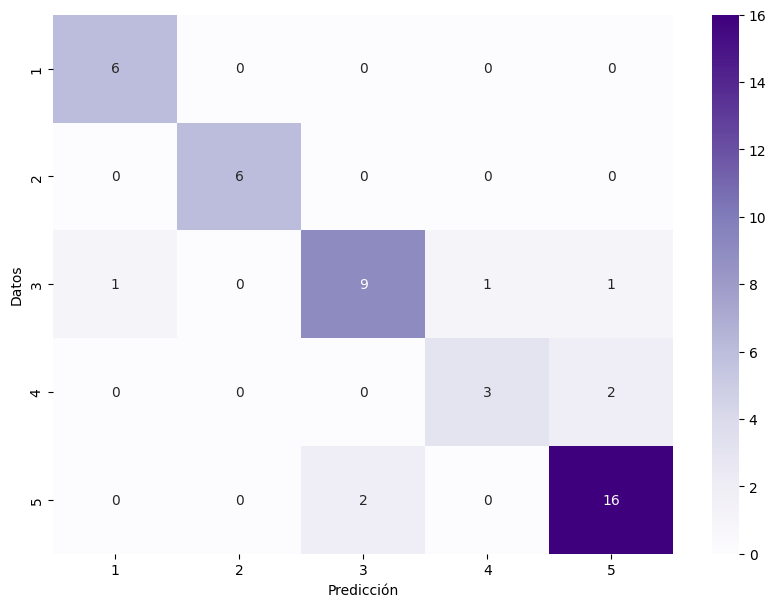

Metrics for different values of k:
k=1: Accuracy=0.7872340425531915, Precision=0.7842392276059359, Recall=0.7872340425531915, F1 Score=0.7831969448990725
k=3: Accuracy=0.851063829787234, Precision=0.8482751850612992, Recall=0.851063829787234, F1 Score=0.8474609954720963
k=5: Accuracy=0.8297872340425532, Precision=0.8275075987841944, Recall=0.8297872340425532, F1 Score=0.8270594653573378
k=7: Accuracy=0.851063829787234, Precision=0.8482751850612992, Recall=0.851063829787234, F1 Score=0.8474609954720963
k=9: Accuracy=0.851063829787234, Precision=0.8482751850612992, Recall=0.851063829787234, F1 Score=0.8474609954720963
k=11: Accuracy=0.851063829787234, Precision=0.8482751850612992, Recall=0.851063829787234, F1 Score=0.8474609954720963
k=13: Accuracy=0.851063829787234, Precision=0.8482751850612992, Recall=0.851063829787234, F1 Score=0.8474609954720963
k=15: Accuracy=0.851063829787234, Precision=0.8453900709219858, Recall=0.851063829787234, F1 Score=0.8437849944008958


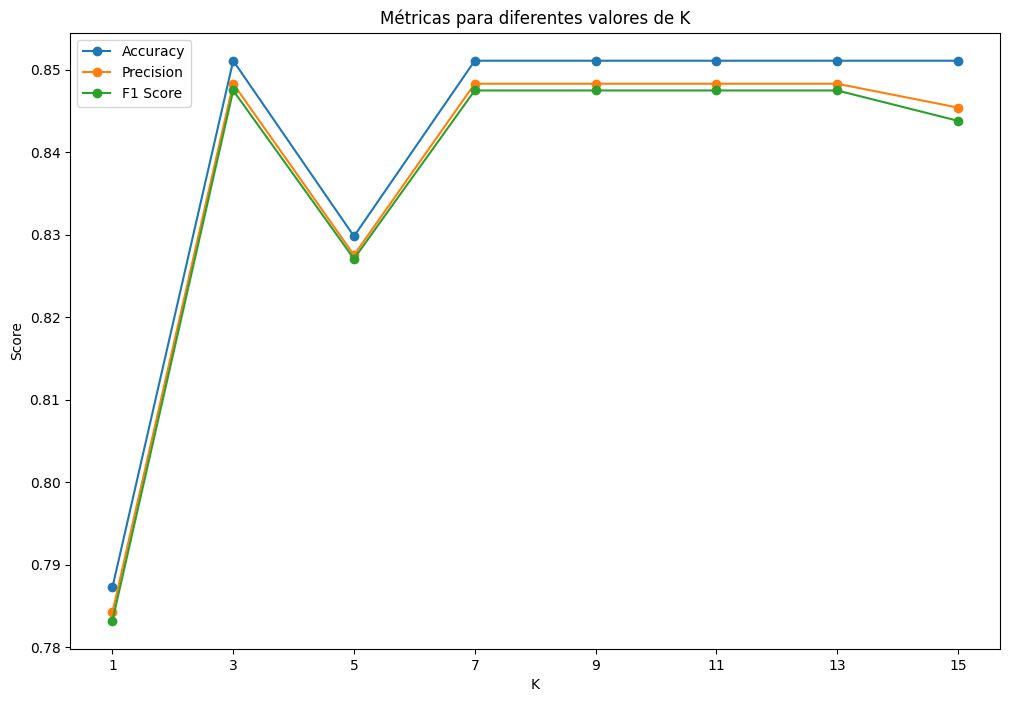

In [288]:
# Evaluar el modelo
print("Accuracy: ", accuracy_score(Y_test, predicciones))
print("Precision: ", precision_score(Y_test, predicciones, average='weighted'))
print("Recall: ", recall_score(Y_test, predicciones, average='weighted'))
print("F1 Score: ", f1_score(Y_test, predicciones, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(Y_test, predicciones))

# make a heatmap of the confusion matrix
import seaborn as sns   
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(Y_test, predicciones), annot=True, fmt='d', cmap='Purples', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicción')
plt.ylabel('Datos')
plt.show()
# different values of k
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
accuracies = []
precisions = []
recalls = []
f1_scores = []

print("Metrics for different values of k:")
for k in k_values:
    predicciones = []
    for punto in X_test:
        prediccion = knn_clasificar(X_train, Y_train, punto, k)
        predicciones.append(prediccion)
    accuracies.append(accuracy_score(Y_test, predicciones))
    precisions.append(precision_score(Y_test, predicciones, average='weighted'))
    recalls.append(recall_score(Y_test, predicciones, average='weighted'))
    f1_scores.append(f1_score(Y_test, predicciones, average='weighted'))
    print(f"k={k}: Accuracy={accuracies[-1]}, Precision={precisions[-1]}, Recall={recalls[-1]}, F1 Score={f1_scores[-1]}")
    
    
# Plot the metrics for different values of k
plt.figure(figsize=(12, 8))
plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.plot(k_values, precisions, marker='o', label='Precision')
#plt.plot(k_values, recalls, marker='o', label='Recall')
plt.plot(k_values, f1_scores, marker='o', label='F1 Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Métricas para diferentes valores de K')
plt.xticks(k_values) 
plt.legend()
plt.show()

# plot the accuracy for different values of k
#plt.figure(figsize=(10, 7))
#plt.plot(k_values, accuracies, marker='o')
#plt.xlabel('k')
#plt.ylabel('Accuracy')
#plt.title('Accuracy for different values of k')
#plt.show()

# plot the precision for different values of k
#plt.figure(figsize=(10, 7))
#plt.plot(k_values, precisions, marker='o')
#plt.xlabel('k')
#plt.ylabel('Precision')
#plt.title('Precision for different values of k')
#plt.show()

# plot the recall for different values of k
#plt.figure(figsize=(10, 7))
#plt.plot(k_values, recalls, marker='o')
#plt.xlabel('k')
#plt.ylabel('Recall')
#plt.title('Recall for different values of k')
#plt.show()

# plot the F1 score for different values of k
#plt.figure(figsize=(10, 7))
#plt.plot(k_values, f1_scores, marker='o')
#plt.xlabel('k')
#plt.ylabel('F1 Score')
#plt.title('F1 Score for different values of k')
#plt.show()

